In [ ]:
from math import pi
from cvxopt import blas, lapack, matrix, sin, mul, normal
try: import pylab
except ImportError: pylab_installed = False
else: pylab_installed = True

# Reconstruction, smoothing, and de-noising

We start with a signal represented by a vector $x \in \mathbb{R}^n$. The coefficients $x_i$ correspond to a sampled (evenly) signal. Suppose this signal does not change that much over time, which means $x_i \approx x_{i+1}$.

If the signal is corrupted (noise):
$$ x_{cor} = x + v \text{,}$$
where $v$ is unknown and rapidly varying. Our goal is to remove this noise.

$$ \min\ \ (\text{w.r.t.} R_{+}^2)\ \ \ (||\hat{x} - x_{cor}||_2,\phi(\hat{x}) \text{,}$$
where $\hat{x}$ is the variable and $x_{cor}$ is a problem parameter. $\phi:\mathbb{R}^n \rightarrow \mathbb{R}^n$ is convex, and is called the regularization function or smoothing objective.

The reconstruction problem seeks signals that are close to the corrupted signal, and that are smooth. This is a convex bi-criterion problem. We can find the [Pareto optimal points](https://web.stanford.edu/group/sisl/k12/optimization/MO-unit5-pdfs/5.8Pareto.pdf) by scalarization, and solving a convex optimization problem.




## Quadratic smoothing

The simplest reconstruction method uses the quadratic smoothing function
$$ \phi_{quad}(x) = \sum_{i=1}^{n-1} (x_{i+1}-x_i)^2 = ||Dx||_2^2 \text{,} $$
where $D\in\mathbb{R}^{(n-1)\times n}$ is the bidiagonal matrix

\begin{bmatrix}
-1 & 1 & 0 & \cdots & 0 & 0 & 0 \\
0 & -1 & 1 & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & -1 & 1 & 0 \\
 0 & 0 & 0 & \cdots & 0 & -1 & 1 \\
\end{bmatrix}

We can obtain the optimal trade-off between $||\hat{x}-x_{cor}||_2$ and $||D\hat{x}||_2$ by minimizing
$$ ||\hat{x}-x_{cor}||_2^2 + \delta ||D\hat{x}||_2^2 \text{,}$$
where $\delta > 0$ parametrizes the optimal trade-off curve. The solution:
$$ \hat{x} = (I + \delta D^T D)^{-1} x_{cor} $$

### Example


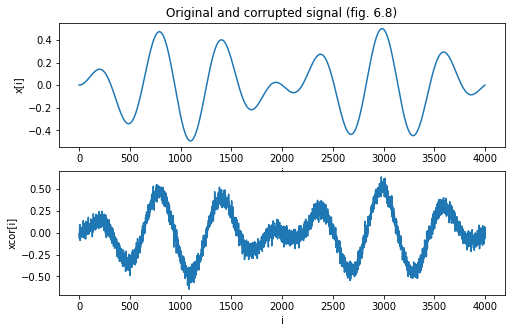

In [2]:
n = 4000
t = matrix(list(range(n)), tc='d')
ex = 0.5 * mul( sin(2*pi/n * t), sin(0.01 * t))
corr = ex + 0.05 * normal(n,1)

if pylab_installed:
    pylab.figure(1, facecolor='w', figsize=(8,5))
    pylab.subplot(211)
    pylab.plot(t, ex)
    pylab.ylabel('x[i]')
    pylab.xlabel('i')
    pylab.title('Original and corrupted signal (fig. 6.8)')
    pylab.subplot(212)
    pylab.plot(t, corr)
    pylab.ylabel('xcor[i]')
    pylab.xlabel('i')

Figure 6.8 shows a signal $x\in \mathbb{R}^{4000}$ (top) and the corrupted signal $x_{cor}$ (bottom).

Let's compute the solution for different values of the parametrization parameter $\delta$.

In [ ]:
# A = D'*D is an n by n tridiagonal matrix with -1.0 on the
# upper/lower diagonal and 1, 2, 2, ..., 2, 2, 1 on the diagonal.
Ad = matrix([1.0] + (n-2)*[2.0] + [1.0])
As = matrix(-1.0, (n-1,1))

nopts = 50
deltas = -10.0 + 20.0/(nopts-1) * matrix(list(range(nopts)))
cost1, cost2 = [], []
for delta in deltas:
    xr = +corr
    lapack.ptsv(1.0 + 10**delta * Ad, 10**delta *As, xr)
    cost1 += [blas.nrm2(xr - corr)]
    cost2 += [blas.nrm2(xr[1:] - xr[:-1])]

# Find solutions with ||xhat - xcorr || roughly equal to 8.0, 3.1, 1.0.
mv1, k1 = min(zip([abs(c - 8.0) for c in cost1], range(nopts)))
xr1 = +corr
lapack.ptsv(1.0 + 10**deltas[k1] * Ad, 10**deltas[k1] *As, xr1)
mv2, k2 = min(zip([abs(c - 3.1) for c in cost1], range(nopts)))
xr2 = +corr
lapack.ptsv(1.0 + 10**deltas[k2] * Ad, 10**deltas[k2] *As, xr2)
mv3, k3 = min(zip([abs(c - 1.0) for c in cost1], range(nopts)))
xr3 = +corr
lapack.ptsv(1.0 + 10**deltas[k3] * Ad, 10**deltas[k3] *As, xr3)

The figure below shows the trade-off curve between the objectives.

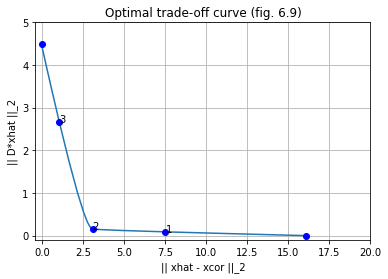

In [3]:
if pylab_installed:
    pylab.figure(2, facecolor='w')
    pylab.plot(cost1, cost2, [blas.nrm2(corr)], [0], 'bo',
        [0], [blas.nrm2(corr[1:] - corr[:-1])], 'bo')
    pylab.plot([cost1[k1]], [cost2[k1]], 'bo', [cost1[k2]], [cost2[k2]], 'bo',
        [cost1[k3]], [cost2[k3]], 'bo')
    pylab.text(cost1[k1], cost2[k1],'1')
    pylab.text(cost1[k2], cost2[k2],'2')
    pylab.text(cost1[k3], cost2[k3],'3')
    pylab.title('Optimal trade-off curve (fig. 6.9)')
    pylab.xlabel('|| xhat - xcor ||_2')
    pylab.ylabel('|| D*xhat ||_2')
    pylab.axis([-0.4, 20, -0.1, 5])
    pylab.grid()

The curve has a clear knee near $3$.

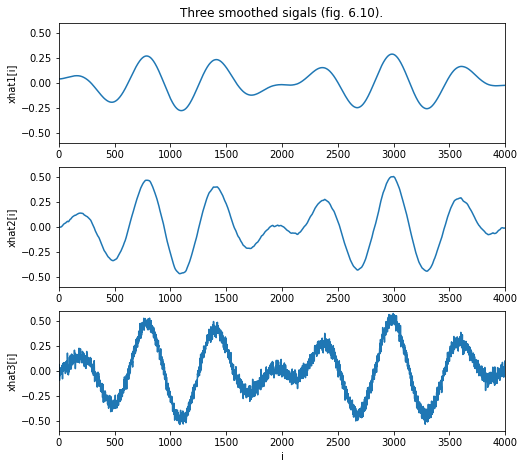

In [4]:
if pylab_installed:
    pylab.figure(3, facecolor='w', figsize=(8,7.5))
    pylab.subplot(311)
    pylab.plot(t, xr1)
    pylab.axis([0, 4000, -0.6, 0.6])
    pylab.ylabel('xhat1[i]')
    pylab.title('Three smoothed sigals (fig. 6.10).')

    pylab.subplot(312)
    pylab.plot(t, xr2)
    pylab.ylabel('xhat2[i]')
    pylab.axis([0, 4000, -0.6, 0.6])

    pylab.subplot(313)
    pylab.plot(t, xr3)
    pylab.axis([0, 4000, -0.6, 0.6])
    pylab.ylabel('xhat3[i]')
    pylab.xlabel('i')
    pylab.show()

Three different approximations.

The top one corresponds to $||\hat{x}-x_{cor}||_2 = 8$.

The middle one to $||\hat{x}-x_{cor}||_2 = 3$.

The bottom one to $||\hat{x}-x_{cor}||_2 = 1$.

# References

https://cvxopt.org/examples/book/smoothrec.html